## P7 - Prep the data 

---

In [15]:
# fmt: off

import warnings

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

warnings.filterwarnings('ignore')


In [99]:
import matplotlib.pyplot as plt
# import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

---

In [16]:
# Fonction Cleaning Finale
def cleaning(features, test_features, encoding="ohe"):
    """Fonction cleaning finale"""
    # Extract the ids
    train_ids = features["SK_ID_CURR"]
    test_ids = test_features["SK_ID_CURR"]

    # Extract the labels for training
    labels = features["TARGET"]

    # Remove the ids and target
    features = features.drop(columns=["SK_ID_CURR", "TARGET"])
    test_features = test_features.drop(columns=["SK_ID_CURR"])

    # One Hot Encoding
    if encoding == "ohe":
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join="inner", axis=1)

        # No categorical indices to record
        cat_indices = "auto"

    # Integer label encoding
    elif encoding == "le":
        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == "object":
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(
                    np.array(features[col].astype(str)).reshape((-1,))
                )
                test_features[col] = label_encoder.transform(
                    np.array(test_features[col].astype(str)).reshape((-1,))
                )

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print("Training Data Shape: ", features.shape)
    print("Testing Data Shape: ", test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Impute the domainnomial features
    imputer = SimpleImputer(strategy="median")

    features = imputer.fit_transform(features)
    test_features = imputer.transform(test_features)

    # Scale the domainnomial features
    scaler = MinMaxScaler(feature_range=(0, 1))

    features = scaler.fit_transform(features)
    test_features = scaler.transform(test_features)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    return feature_names, labels, features, test_features, train_ids, test_ids


In [121]:
# Training data
app_train = pd.read_csv("../../data/raw/application_train.csv")
print("Training data shape: ", app_train.shape)
app_train.head(2)

# Testing data features
app_test = pd.read_csv("../../data/raw/application_test.csv")
print("Testing data shape: ", app_test.shape)
app_test.head(2)

# copy to add fe
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

# feature engineering with domain knowledge variables
app_train_domain["CREDIT_INCOME_PERCENT"] = (
    app_train_domain["AMT_CREDIT"] / app_train_domain["AMT_INCOME_TOTAL"]
)
app_train_domain["ANNUITY_INCOME_PERCENT"] = (
    app_train_domain["AMT_ANNUITY"] / app_train_domain["AMT_INCOME_TOTAL"]
)
app_train_domain["CREDIT_TERM"] = (
    app_train_domain["AMT_ANNUITY"] / app_train_domain["AMT_CREDIT"]
)
app_train_domain["DAYS_EMPLOYED_PERCENT"] = (
    app_train_domain["DAYS_EMPLOYED"] / app_train_domain["DAYS_BIRTH"]
)

app_test_domain["CREDIT_INCOME_PERCENT"] = (
    app_test_domain["AMT_CREDIT"] / app_test_domain["AMT_INCOME_TOTAL"]
)
app_test_domain["ANNUITY_INCOME_PERCENT"] = (
    app_test_domain["AMT_ANNUITY"] / app_test_domain["AMT_INCOME_TOTAL"]
)
app_test_domain["CREDIT_TERM"] = (
    app_test_domain["AMT_ANNUITY"] / app_test_domain["AMT_CREDIT"]
)
app_test_domain["DAYS_EMPLOYED_PERCENT"] = (
    app_test_domain["DAYS_EMPLOYED"] / app_test_domain["DAYS_BIRTH"]
)

# Create an anomalous flag column
app_train_domain["DAYS_EMPLOYED_ANOM"] = app_train_domain["DAYS_EMPLOYED"] == 365243
# Replace the anomalous values with nan
app_train_domain["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)

app_test_domain["DAYS_EMPLOYED_ANOM"] = app_test_domain["DAYS_EMPLOYED"] == 365243
app_test_domain["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)


app_train_domain["DAYS_EMPLOYED_ANOM"] = app_train_domain["DAYS_EMPLOYED_ANOM"].astype(
    "int32"
)
app_test_domain["DAYS_EMPLOYED_ANOM"] = app_test_domain["DAYS_EMPLOYED_ANOM"].astype(
    "int32"
)

Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)


In [ ]:
# if "TARGET" in app_train_domain.columns.tolist():
#    app_train_domain = app_train_domain.drop(columns="TARGET")

# domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
# imputer = SimpleImputer(strategy="median")

# domain_features = imputer.fit_transform(app_train_domain)
# domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
# scaler = MinMaxScaler(feature_range=(0, 1))

# domain_features = scaler.fit_transform(domain_features)
# domain_features_test = scaler.transform(domain_features_test)


In [148]:
liste_features, labels, X_train, X_test, train_ids, test_ids = cleaning(
    app_train_domain, app_test_domain, encoding="ohe"
)
train_final = pd.DataFrame(X_train, columns=liste_features)
train_final["LABELS"] = labels
train_final["SK_ID_CURR"] = train_ids

test_final = pd.DataFrame(X_test, columns=liste_features)
test_final["SK_ID_CURR"] = test_ids


Training Data Shape:  (307511, 246)
Testing Data Shape:  (48744, 246)


---

## Models

In [86]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [123]:
params = {
    "n_estimators": 100,
    "random_state": 50,
    "verbose": 1,
    "n_jobs": -1,
}

random_forest_domain = RandomForestClassifier(**params)

# Train on the training data
random_forest_domain.fit(X_train, labels)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.3s finished


RandomForestClassifier(n_jobs=-1, random_state=50, verbose=1)

In [126]:
# Make predictions on the test data
# first row is proba of the target being 0 and the second row is the proba of the target being 1. We want the second row
y_pred = random_forest_domain.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.2s finished


In [127]:
y_pred_classes = (y_pred >= 0.5).astype(int)

# Now calculate accuracy
accuracy = accuracy_score(np.argmax(X_test, axis=1), y_pred_classes)

In [129]:
print(f"{accuracy:.4f}")

0.0000


In [95]:
tes = pd.DataFrame(y_pred)

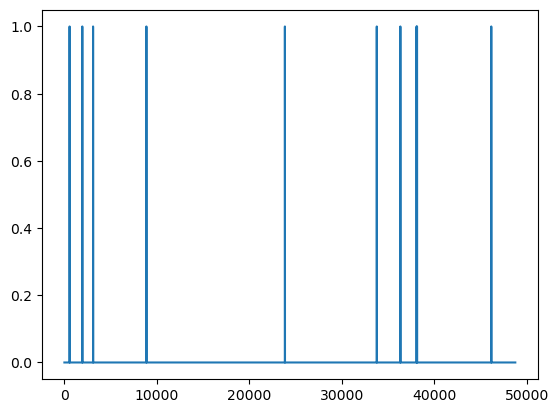

In [114]:
plt.plot(y_pred_classes)

In [109]:
labels.value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [113]:
y_pred_classes

array([0, 0, 0, ..., 0, 0, 0], shape=(48744,))

In [89]:
np.argmax(X_test, axis=1)

array([ 3,  3,  2, ...,  2, 20,  2], shape=(48744,))

In [150]:
classification_report(X_test, y_pred)

ValueError: Classification metrics can't handle a mix of continuous-multioutput and continuous targets

---

# MLflow

In [72]:
import mlflow
from mlflow.models import infer_signature

In [152]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Create a new MLflow Experiment
mlflow.set_experiment("MLflow Quickstart")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    # mlflow.log_metric("accuracy", accuracy)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for iris data")

    # Infer the model signature
    signature = infer_signature(X_train, random_forest_domain.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=random_forest_domain,
        artifact_path="iris_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="tracking-quickstart",
    )

KeyboardInterrupt: 